# Apartat (C): Analitzant Dades

L'objectiu d'aquest primer apartat serà conèixer la base de dades que es té entre mans. S'han d'analitzar els diferents atributs que la composen, entendre'ls i, si no està estipulat, **caldrà fixar quin es l'atribut objectiu a predir de tots els que hi ha a la base de dades**, justificant el per què de la decisió (és útil i representatiu pel problema, per exemple, donat un conjunt de dades sobre persones: edat, gènere, pes, alçada, risc de patir càncer, aquesta última pot ser justificada com la de més interés). També podeu mirar que l'atribut objectiu tingui valors que canvien. Per exemple, no té sentit predir un atribut on el 99% dels valors són 0, i hi ha algun 1.

Ara podeu veure un exemple amb una base de dades **dummy** que creem nosaltres mateixos:

In [32]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.stats

# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('data/OnionPrices.csv')
del dataset["commodity"]

df_filtered = dataset[(dataset['max_price'] != 0)]
dataset = df_filtered[(df_filtered['min_price'] != 0)]

data = dataset.values
x = data[:, :]
y_modal_price = data[:, -1]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y_modal_price.shape)


Dimensionalitat de la BBDD: (107105, 8)
Dimensionalitat de les entrades X (107105, 8)
Dimensionalitat de l'atribut Y (107105,)


In [33]:
print("Per comptar el nombre de valors no existents:")
print(dataset.isnull().sum())

Per comptar el nombre de valors no existents:
state           0
district        0
market          0
variety         0
arrival_date    0
min_price       0
max_price       0
modal_price     0
dtype: int64


In [34]:
print("Per visualitzar les primeres 5 mostres de la BBDD:")

dataset.head() 

Per visualitzar les primeres 5 mostres de la BBDD:


,state,district,market,variety,arrival_date,min_price,max_price,modal_price
0,Andhra Pradesh,Kurnool,Kurnool,Local,03/01/2020,1350,4390,3100.000
1,Andhra Pradesh,Kurnool,Kurnool,Local,04/01/2020,1390,4400,3200.000
2,Andhra Pradesh,Kurnool,Kurnool,Local,06/01/2020,1460,5150,4310.000
3,Andhra Pradesh,Kurnool,Kurnool,Local,07/01/2020,2010,5200,4200.000
4,Andhra Pradesh,Kurnool,Kurnool,Local,10/01/2020,1320,4050,3300.000


In [35]:
# Valores unicos sobre los atributos
print("Numero de mercados:", len(dataset['market'].unique()))
print("Numero de distritos:", len(dataset['district'].unique()))
print("Numero de estados:", len(dataset['state'].unique()))
print("Numero de variedad:", len(dataset['variety'].unique()))

Numero de mercados: 905
Numero de distritos: 315
Numero de estados: 22
Numero de variedad: 21


In [36]:
print("Per veure estadístiques dels atributs numèrics de la BBDD:")
dataset.describe()

Per veure estadístiques dels atributs numèrics de la BBDD:


,min_price,max_price,modal_price
count,107105.000,107105.000,107105.000
mean,1896.110,2293.933,2109.441
std,1459.381,1564.327,1493.184
min,20.000,54.000,20.000
25%,1000.000,1225.000,1150.000
50%,1400.000,1800.000,1600.000
75%,2400.000,2800.000,2550.000
max,18000.000,25000.000,22000.000


In [37]:
# Es transforme l'atribut arrival_time que es un objecte al tipus data
dataset['arrival_date'] = pd.to_datetime(dataset['arrival_date'])
dataset.head()
print(dataset.dtypes)

state                   object
district                object
market                  object
variety                 object
arrival_date    datetime64[ns]
min_price                int64
max_price                int64
modal_price            float64
dtype: object


/tmp/ipykernel_83/3279935929.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dataset['arrival_date'] = pd.to_datetime(dataset['arrival_date'])
/tmp/ipykernel_83/3279935929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['arrival_date'] = pd.to_datetime(dataset['arrival_date'])


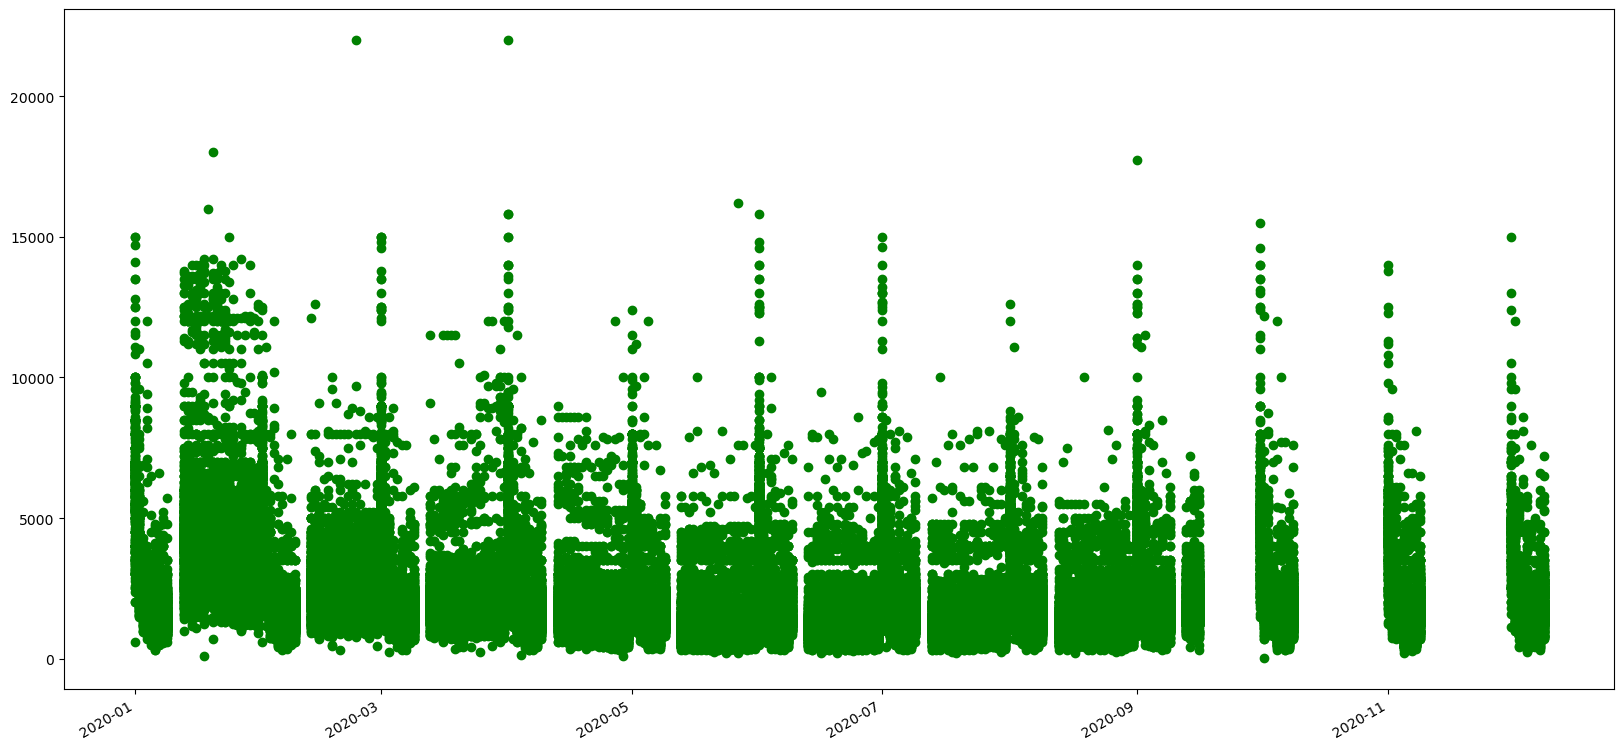

In [45]:
fig = plt.figure(figsize=(20, 10))
#plt.scatter(x= dataset['variety'], y = dataset['modal_price'], c='green')
plt.scatter(x= dataset['arrival_date'], y = dataset['modal_price'], c='green')
#plt.scatter(x= dataset['arrival_date'], y = dataset['min_price'], c='red')
#plt.scatter(x= dataset['arrival_date'], y = dataset['max_price'], c='blue')
plt.gcf().autofmt_xdate()
plt.show()

In [41]:
# mostrem atribut 0
plt.figure(figsize=(20,10))
for i in range(7):
    ax = plt.scatter(x[:,i], y_modal_price)
    plt.gcf().autofmt_xdate()
    plt.savefig("images/scatter" + str(i) + ".png", dpi = 300, bbox_inches = 'tight')
    plt.clf()
    

<Figure size 2000x1000 with 0 Axes>

In [42]:
plt.figure(figsize=(30,10))
plt.title("Histograma de l'atribut 0")
plt.xlabel("Attribute Value")
plt.ylabel("Count")

hist = plt.hist(x[:,-1],  rwidth=0.2)
plt.gcf().autofmt_xdate()
plt.savefig("images/histModalPrice.png",dpi = 300, bbox_inches = 'tight')
plt.clf()

for i in range(7):
    hist = plt.hist(x[:,i] , bins=len( set(x[:,i])),  rwidth=0.2)
    plt.gcf().autofmt_xdate()
    plt.savefig("images/hist" + str(i) + ".png", dpi = 300, bbox_inches = 'tight')
    plt.clf()

<Figure size 3000x1000 with 0 Axes>

També podem estudiar la correlació entre els diferents atributs per tal de saber si estan correlacionats entre ells.

/tmp/ipykernel_83/2629687752.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlacio = dataset.corr()


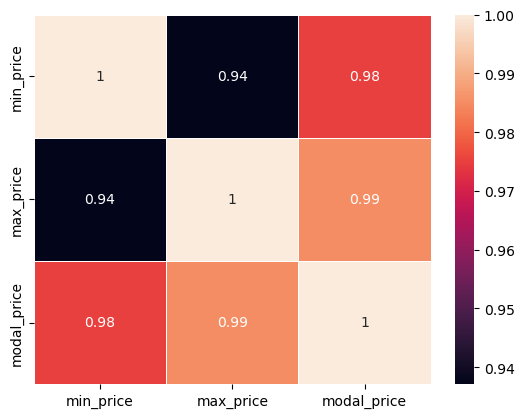

In [43]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dataset.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

També podem utilitzar la funció pairplot per tal de veure els atributs que estan relacionats entre si.

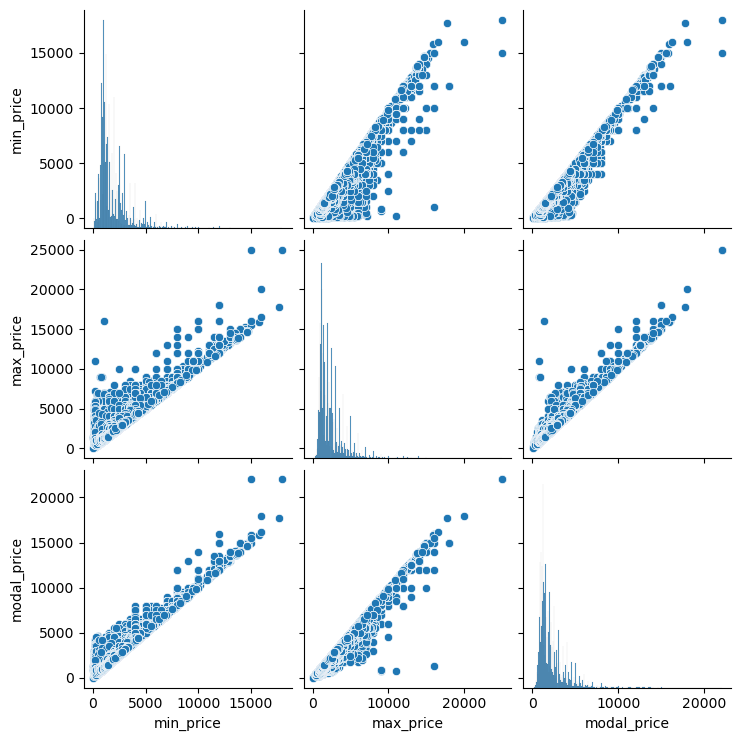

In [44]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset)
plt.savefig("data/correlacio.png", dpi = 300, bbox_inches = 'tight')

Així doncs ara podreu respondre a les següents preguntes:

1. Quin és el tipus de cada atribut?

2. Quins atributs tenen una distribució Guassiana?
3. Quin és l'atribut objectiu? Per què?

# Apartat (B): Primeres regressions

Per a aquest primer apartat es calcularà l'error quadràtic mitjà només del regressor per a cada un dels atributs de la base de dades, determinant aquell atribut pel qual l'error quadràtic mitjà (entre el valor predit i el real, per a cada mostra) és més baix. 

A continuació se us dona una funció auxiliar per a calcular l'error quadràtic mitjà:

In [22]:
import math

def mean_squeared_error(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

mean_squeared_error([1,2,3,4], [1,2,1,4])

1.0

Per a agilitzar els càlculs es recomana utilitzar la llibreria numpy. Aquesta llibreria ens permet processar vectors sencers a la vegada de manera eficient i en paral·lel. Exemple:

In [23]:
import numpy as np #importem la llibreria
np.warnings.filterwarnings('ignore')

vector1 = np.array([1,2,3,4]) # convertim llista de python a numpy array
vector2 = np.array([1,2,1,4]) 

# podem sumar dos vectors element a element
print("Suma vector1 + vector2 ", vector1 + vector2)

# podem sumar tots els valors d'un vector
print("Suma valors vector1 ", vector1.sum())

# calculem la mitjana
print("Mitjana vector1", vector1.mean())

# utilitzem un vector com a índex de l'altre
# vector3 = vector1  # necesitem fer una copia del vector per no modificar el original
vector3 = vector1.copy()
vector3[vector2 == 1] = 5
print("Vector1 amb un 5 on el Vector2 te 1s ", vector3)

# es pot utilitzar numpy per a calcular el mse
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

print("MSE: ", mse(vector1, vector2))

Suma vector1 + vector2  [2 4 4 8]
Suma valors vector1  10
Mitjana vector1 2.5
Vector1 amb un 5 on el Vector2 te 1s  [5 2 5 4]
MSE:  1.0


Per a la regressió podeu utilitzar la llibreria sklearn:

In [24]:
from sklearn.linear_model import LinearRegression

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

Finalment, si la funció `fit` del regressor logístic dónes l'error: `ValueError: Unknown label type: 'unknown'`, caldria afegir a la definició de l'atribut a trobar $y$ la crida a la funció `.astype('int')` per tal de obligar a que les dades siguin de tipus sencer, deixant el codi com segueix:

`y = data[:,2].astype('int')`

A continuació, es modificaran tots els atributs mitjançant **procediments de normalització (normal, estàndard)**, i s'avaluarà el rendiment del regressor après. Per a això, caldrà analitzar la mitja i variança de cada variable per totes les mostres, per identificar aquells valors que tenen una distribució normal, els preferits per fer regressió, i descartar altres atributs que no són representatius per fer la regressió, i que afegeixen soroll al model. 

Pel que fa a l'error resultant de la regressió, recordeu que es calcula fent la diferència entre el valor predit i el real al quadrat: així doncs, si les dades tenen valors grans (tipus 10^3), l'error al quadrat podria acabar sent 10^6. Per això és important normalitzar abans (escalar les dades a un rang més petit).

<img src="images/standarization.png">

Podeu estandarditzar les dades amb les funcions mean i std de numpy i mostrar l'hisotgrama de nou. Recuperant l'exemple de l'apartat anterior:

In [25]:
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

x_t = standarize(x.astype('int'))

ValueError: invalid literal for int() with base 10: 'Andhra Pradesh'

Ara ja podeu comprovar la diferència entre entrenar amb els atributs estandaritzats i si aquells que tenen una distribució més semblant a la normal donen millors resultats. 
Finalment, s'aprendrà un model regressor tenint en compte tots aquells atributs que tenen una millor distribució de valors (lineal, això és, l'histograma de valors té forma de gaussiana), i es calcularà l'error assolit en la predicció. 

Recordeu que el valor sobre el que heu de fer la regressió queda al vostre criteri: **heu d'explicar a la memòria quin atribut heu fet servir, no hi ha una decisió única correcta, cal que doneu raons de per què heu triat l'atribut que hàgiu triat.**

Així per exemple pode mirar:

* Que l'objectiu de la regressió sigui un valor ordinal (1 > 2 > 3). Si no n'hi ha cap, explicar-ho a la memòria.

* Que sigui útil en alguna aplicació real (per exemple predir si plourà és més interessant que predir el color dels núvols).

* Que tingui certa variació (un atribut que és sempre 0, no té gaire interès)

I en definitiva explicar el criteri a seguir, tant amb paraules com amb gràfiques (per exemple histograma), o estadístiques (per exemple la variança dels atributs) si escau.

Un cop escollit l'atribut objectiu, caldrà justificar si l'error obtingut és, en proporció, menor que tenint en compte únicament el millor atribut identificat al primer punt. 

Podeu utilitzar les funcions hist de matplotlib per a calcular els histogrames. Exemple:

In [48]:
plt.figure()
plt.title("Histograma de l'atribut 0")
plt.xlabel("Attribute Value")
plt.ylabel("Count")
hist = plt.hist(x_t[:,0], bins=11, range=[np.min(x_t[:,0]), np.max(x_t[:,0])], histtype="bar", rwidth=0.8)

<IPython.core.display.Javascript object>

o utilitzar les funcions de visualitzación del propi pandas.

In [49]:
dataset.drop(['attr2'],1).hist()

KeyError: "['attr2'] not found in axis"

Ara que hem carregat les dades podem entrenar un regressor lineal per a aproximar la funció que les genera:

In [ ]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
atribut1 = x[:,0].reshape(x.shape[0], 1) 
regr = regression(atribut1, y) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(x[:,0], y)
plt.plot(atribut1[:,0], predicted, 'r')

# Mostrem l'error (MSE i R2)
MSE = mse(y, predicted)
r2 = r2_score(y, predicted)

print("Mean squeared error: ", MSE)
print("R2 score: ", r2)


Un cop mostrats de manera adient, (en forma de taula, i/o de gràfics si la dimensionalitat ho permet) els resultats aconseguits amb la regressió, avaluarem de manera independent la idonietat de cadascun dels atributs.

In [ ]:
""" Per a assegurar-nos que el model s'ajusta be a dades noves, no vistes, 
cal evaluar-lo en un conjunt de validacio (i un altre de test en situacions reals).
Com que en aquest cas no en tenim, el generarem separant les dades en 
un 80% d'entrenament i un 20% de validació.
"""
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(x, y)

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = regression(x_t, y_train)    
    error = mse(y_val, regr.predict(x_v)) # calculem error
    r2 = r2_score(y_val, regr.predict(x_v))

    print("Error en atribut %d: %f" %(i, error))
    print("R2 score en atribut %d: %f" %(i, r2))


Quan es treballa en dades n-dimensionals (més d'un atribut), una opció és reduir la seva n-dimensionalitat aplicant un Principal Component Analysis (PCA) i quedar-se amb els primers 2 o 3 components, obtenint unes dades que (ara sí) poden ser visualitzables en el nou espai. Existeixen altres embeddings de baixa dimensionalitat on poder visualitzar les dades?

Així es podrà contestar a aquestes **preguntes**:

1. Quin són els atributs més importants per fer una bona predicció?

2. Amb quin atribut s'assoleix un MSE menor?

3. Quina correlació hi ha entre els atributs de la vostra base de dades?

4. Com influeix la normalització en la regressió?

5. Com millora la regressió quan es filtren aquells atributs de les mostres que no contenen informació?

6. Si s'aplica un PCA, a quants components es redueix l'espai? Per què?


# Apartat (A): El descens del gradient  

En aquest exercici, es tracta d'implementar en python el procés de descent del gradient explicat a les classes de teoria, i comparar-lo amb els resultats obtinguts amb l'apartat (B). 

$$J(w) = \frac{1}{2m} \left[ \sum^m_{i=1}(f(x^{i}; w) - y^{i})^2 + \lambda\sum_{j=1}^{n}(w_{j}^2) \right]$$

Fixeu-vos que $J$ retorna el `mse`. Per a trobar $w_j$, repetir fins convergència:
$$w_0 = w_0 - \alpha \frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot 1$$
$$w_j = w_j - \alpha \left[\frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i} - \frac{\lambda}{m}w_{j} \right]$$


ó:

$$w_{j} := w_{j} \left(1-\alpha \frac{\lambda}{m} \right) - \alpha\frac{\lambda}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i}$$

On si considerem un regressor lineal (el model és una recta), llavors $w_0$ i $w_1$ representen, respectivament, la $b$ i $a$ de la fòrmula de la recta: 

$$h_\theta(x^{(i)}) = ax + b$$

$\alpha$ és el learning rate, i $h_\theta(x^{(i)})$ és la funció que fa la regressió, és a dir, la funció que prediu el valor de $y^{(i)}$ donat un(s) atribut(s) concret(s) $x^{(i)}$.

Així, tenint calculat el model en l'últim punt del primer exercici, ja sabeu quin resultat hauríeu d'obtenir. O no, perquè la vostra implementació pot ser millor! En concret, es tracta de desenvolupar aquestes tasques:

* Definir la funció de cost i del gradient

* Estudiar com l'ús de regularitzadors afecta el resultat: overfitting, underfitting, etc. 

* Visualització de les dades a analitzar i explicació pas a pas del procediment   

* Visualització del procés de descens de gradient 

* Modificar el learning rate i el nombre d'iteracions 

<img src="images/gradient_descent.png">

Per a la implementació us podeu basar en el següent esquelet:

In [ ]:
class Regressor(object):
    def __init__(self, w0, w1, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.alpha = alpha

        
    def predict(self, x):
        # implementar aqui la funció de prediccio
        pass
    
    def __update(self, hy, y):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        pass
    
    def train(self, max_iter, epsilon):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        pass

L'últim pas serà validar el regressor trobat pel descent del gradient desenvolupat en aquest apartat visualment, aplicat a un model de recta i un model de pla. Per a això, caldrà considerar el millor atribut identificat en el primer punt de l'anterior entrega per visualitzar la línia regressora en 2D (podeu mostrar dades 2d amb la funció scatter). Després, dos dels atributs identificats a l'últim punt del primer exercici per visualitzar el pla regressor en 3D (En el cas 3D l’scatter s’ha de fer sobre una figura amb projecció 3D).

In [ ]:
%matplotlib notebook

# Creem figura 3d
from mpl_toolkits.mplot3d import axes3d, Axes3D
# generem dades 3D d'exemple
x_val = np.random.random((100, 2))
y_val = np.random.random((100, 1))
regr = regression(x_val, y_val)
predX3D = regr.predict(x_val)

# Afegim els 1's
A = np.hstack((x_val,np.ones([x_val.shape[0],1])))
w = np.linalg.lstsq(A,predX3D)[0]

#Dibuixem
#1r creem una malla acoplada a la zona de punts per tal de representar el pla
malla = (range(20) + 0 * np.ones(20)) / 10 
malla_x1 =  malla * (max(x_val[:,0]) - min(x_val[:,0]))/2 + min(x_val[:,0])
malla_x2 =  malla * (max(x_val[:,1]) - min(x_val[:,1]))/2 + min(x_val[:,1])

#la funcio meshgrid ens aparella un de malla_x1 amb un de malla_x2, per atot
#element de mallax_1 i per a tot element de malla_x2.
xplot, yplot = np.meshgrid(malla_x1 ,malla_x2)

# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean

#ara creem la superficies que es un pla
zplot = w[0] * xplot + w[1] * yplot + w[2]

#Dibuixem punts i superficie
plt3d = plt.figure('Coeficiente prismatico -- Relacio longitud desplacament 3D', dpi=100.0).gca(projection='3d')
plt3d.plot_surface(xplot,yplot,zplot, color='red')
plt3d.scatter(x_val[:,0],x_val[:,1],y_val)

Així es podrà contestar a aquestes preguntes:

1. Com influeixen tots els paràmetres en el procés de descens? Quins valors de learning rate convergeixen més ràpid a la solució òptima? Com influeix la inicialització del model en el resultat final? 

2. Quines funcions polinomials (de diferent grau, de diferents combinacions d'atributs, ...) heu escollit per ser apreses amb el vostre descens del gradient? quina ha donat el millor resultat (en error i rapidesa en convergència)?

3. Utilitzeu el regularitzador en la fòrmula de funció de cost i descens del gradient i proveu polinomis de diferent grau. Com afecta el valor del regularitzador?

3. Quina diferència (quantitativa i qualitativa) hi ha entre el vostre regressor i el de la llibreria ?

4. Té sentit el model (polinomial) trobat quan es visualitza sobre les dades? 

5. Ajuda la visualització a identificar aquelles mostres per a les que el regressor obté els pitjors resultats de predicció? 
